In [1]:
import xarray as xr
import gcsfs
from glob import glob
from tqdm import tqdm
from dask.diagnostics import ProgressBar, Profiler
import dask
import os
import shutil
import numpy as np
from dask.distributed import Client, LocalCluster
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output


In [2]:
ddir = '/swot/SUM03/tmp/CESM/'

In [3]:
client = Client('tcp://129.236.21.48:8089')
client

Client Scheduler: tcp://129.236.21.48:8089 Dashboard: http://129.236.21.48:8787/status,Cluster Workers: 16 Cores: 16 Memory: 8.66 TB


In [4]:
ds=xr.open_zarr(ddir+'hybrid_v5_rel04_BC5_ne120_t12_pop62', auto_chunk=False).chunk({'time': 1})
ds

/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)


<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    ANGLE               (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    ANGLET              (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HT                  (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HTE                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HTN                 (nlat, nlon) float64 dask.

In [5]:
from xbatcher import BatchGenerator

In [6]:
ds=ds.rename({'U1_1':'U', 'V1_1':'V', 'TAUX_2':'TAUX', 'TAUY_2':'TAUY', 'SSH_2':'SSH', 'ULONG':'XU', 'ULAT':'YU'})

In [7]:
def threeD_coords(lon,lat):
    X = np.sin(np.radians(lat))
    Y = np.sin(np.radians(lon))*np.cos(np.radians(lat))
    Z = -np.cos(np.radians(lon))*np.cos(np.radians(lat))
    return (X,Y,Z)

def extract_needed_variables(batch):
    shift_vars = ['SSH','XU','YU']
    coord_vars = ['XU','YU']

    shifts = {'_e': dict(nlon_input=-1),
              '_w': dict(nlon_input=1),
             '_n': dict(nlat_input=-1),
             '_s': dict(nlat_input=1),
             '_ne': dict(nlon_input=-1,nlat_input=-1),
             '_nw': dict(nlon_input=1,nlat_input=-1),
             '_se': dict(nlon_input=-1,nlat_input=1),
             '_sw': dict(nlon_input=1,nlat_input=1),}

    for suf, shift in shifts.items():
        for var in shift_vars:
            batch[var + suf] = batch[var].shift(**shift)
            
    suffixes = ['','_e','_w','_n','_s','_ne','_nw','_se','_sw']
    for suf in suffixes:
        batch['X'+suf],batch['Y'+suf],batch['Z'+suf], = threeD_coords(batch['XU'+suf],batch['YU'+suf])
    for var in coord_vars:
        for suf in suffixes:
            batch = batch.drop([var+suf])
    return batch

targets=['U','V']
feature_cols = ['X', 'Y', 'Z',
                'X_e','X_w','X_n','X_s','X_ne','X_se','X_nw','X_sw',
                'Y_e','Y_w','Y_n','Y_s','Y_ne','Y_se','Y_nw','Y_sw',
                'Z_e','Z_w','Z_n','Z_s','Z_ne','Z_se','Z_nw','Z_sw',
                'TAUX','TAUY','SST','SSH',
                'SSH_e','SSH_w','SSH_n','SSH_s','SSH_ne','SSH_se','SSH_nw','SSH_sw']
from sklearn.model_selection import train_test_split

def ds_to_df(batch, w_validation=False, choice='training'):
    df = batch.reset_index('sample').to_dataframe()
    #X = df.sort_values('time').dropna().reset_index(drop=True).loc[:, feature_cols]
    #y = df.sort_values('time').dropna().reset_index(drop=True).loc[:, targets]
    X = df.dropna().reset_index(drop=True).loc[:, feature_cols]
    y = df.dropna().reset_index(drop=True).loc[:, targets]
    if w_validation:
        X,X_t,y,y_t = train_test_split(X,y,test_size=0.2)
        if (choice=='training'):
            return (X,y)
        elif (choice=='validation'):
            return (X_t,y_t)
    else:
        return (X,y)
    

In [8]:
def actual_generator(**kwargs):
    vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V']
    bg = BatchGenerator(ds.reset_coords()[vars_wanted],
                    input_dims={'nlon': 100, 'nlat': 100}, batch_dims={'time': 1},
                    input_overlap={'nlon' : 1, 'nlat' : 1},
                    concat_input_dims=True)
    for batch in bg:
        yield  ds_to_df(extract_needed_variables(batch), kwargs)

In [9]:
import tensorflow as tf
from tensorflow import keras

/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [19]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(40, activation=tf.nn.relu,
                       input_shape=(len(feature_cols),),
                       name='hidden_layer_1',),
    keras.layers.Dense(20, activation=tf.nn.relu, 
                       name='hidden_layer_2'),
    keras.layers.Dense(10, activation=tf.nn.relu, 
                       name='hidden_layer_3'),
    keras.layers.Dense(2, name='output_layer',)
])

# Define your optimizer asdf
optimizer = tf.train.AdamOptimizer()
model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])

# show a summary of the data
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 40)                1600      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 20)                820       
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 10)                210       
_________________________________________________________________
output_layer (Dense)         (None, 2)                 22        
Total params: 2,652
Trainable params: 2,652
Non-trainable params: 0
_________________________________________________________________


In [20]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 14, 'axes.labelsize' : 12,
      'legend.fontsize' : 13,'legend.handlelength': 3})

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

lw=2
aph=.2

plt.rcParams['figure.figsize'] = (9.,6.)



In [21]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel('Mean Square Error');
        plt.show();
        
plot_losses = PlotLosses()

# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 5])

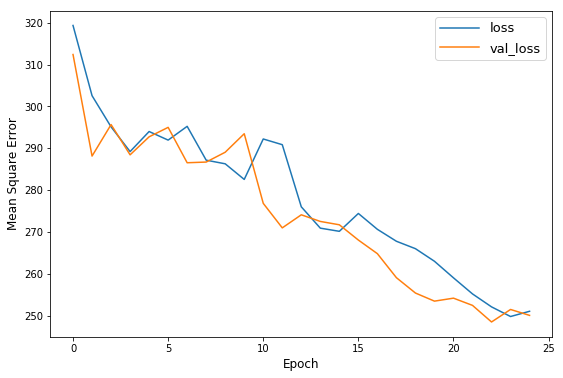

5/5 [==============================] - 467s 93s/step - loss: 251.0773 - mean_absolute_error: 10.0062 - mean_squared_error: 251.0773 - val_loss: 250.1012 - val_mean_absolute_error: 9.9298 - val_mean_squared_error: 250.1012


In [22]:
model_hist = model.fit_generator(generator=actual_generator(w_validation=True, choice='training'),
                                 validation_data=actual_generator(w_validation=True, choice='validation'),
                                 steps_per_epoch=5, validation_steps=5, epochs=25, callbacks=[plot_losses])#, use_multiprocessing=True, workers=10)


In [23]:
print(model_hist.history.keys())

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_mean_squared_error', 'loss', 'mean_absolute_error', 'mean_squared_error'])


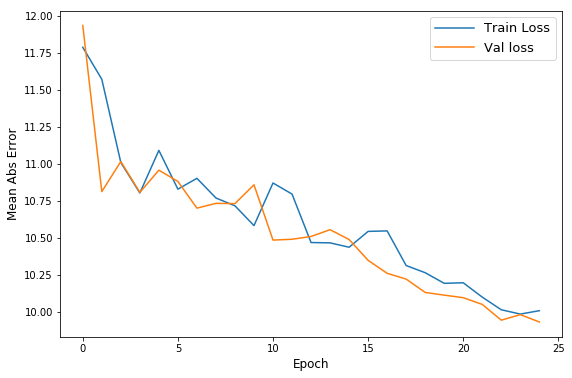

In [24]:
plot_history(model_hist)

In [38]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(40, activation=tf.nn.relu,
                       input_shape=(len(feature_cols),),
                       name='hidden_layer_1',),
    keras.layers.Dense(20, activation=tf.nn.relu, 
                       name='hidden_layer_2'),
    keras.layers.Dense(10, activation=tf.nn.relu, 
                       name='hidden_layer_3'),
    keras.layers.Dense(2, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
model.compile(loss='mse',
            optimizer='adam',
            metrics=['mae', 'mse', 'accuracy'])

# show a summary of the data
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 40)                1600      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 20)                820       
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 10)                210       
_________________________________________________________________
output_layer (Dense)         (None, 2)                 22        
Total params: 2,652
Trainable params: 2,652
Non-trainable params: 0
_________________________________________________________________


In [39]:
plt.rcParams['figure.figsize'] = (14.,5.)


In [40]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('acc'))
        self.val_accuracy.append(logs.get('val_acc'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel('Mean Square Error');
        plt.subplot(122)
        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.plot(self.x, self.val_accuracy, label="val_accuracy")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel('Model Accuracy');
        plt.show();
        
plot_losses = PlotLosses()

# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 5])

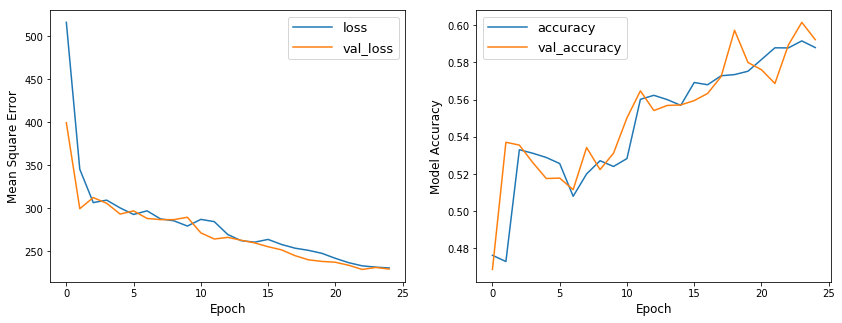

5/5 [==============================] - 430s 86s/step - loss: 230.3880 - mean_absolute_error: 9.5718 - mean_squared_error: 230.3880 - acc: 0.5880 - val_loss: 229.1000 - val_mean_absolute_error: 9.5072 - val_mean_squared_error: 229.1000 - val_acc: 0.5923


In [41]:
model_hist = model.fit_generator(generator=actual_generator(w_validation=True, choice='training'),
                                 validation_data=actual_generator(w_validation=True, choice='validation'),
                                 steps_per_epoch=5, validation_steps=5, epochs=25, callbacks=[plot_losses])#, use_multiprocessing=True, workers=10)


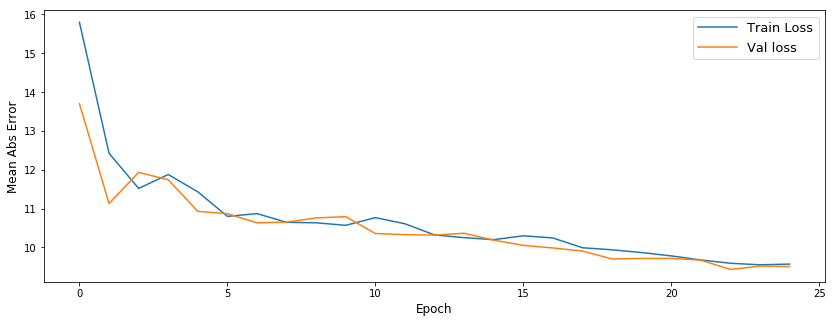

In [42]:
plot_history(model_hist)

In [43]:
model.save_weights('./model_checkpoints/weights_batch100_3layer_402010_125d')
model.save('./model_checkpoints/model_batch100_3layer_402010_125d')

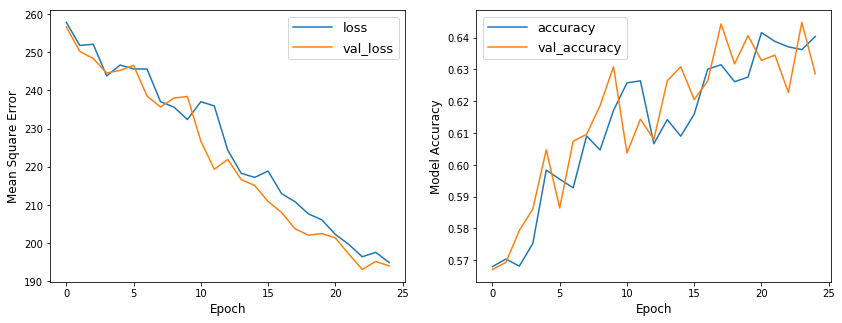

5/5 [==============================] - 443s 89s/step - loss: 194.8956 - mean_absolute_error: 8.6851 - mean_squared_error: 194.8956 - acc: 0.6404 - val_loss: 194.0036 - val_mean_absolute_error: 8.7192 - val_mean_squared_error: 194.0036 - val_acc: 0.6286


In [44]:
model_hist2 = model.fit_generator(generator=actual_generator(w_validation=True, choice='training'),
                                 validation_data=actual_generator(w_validation=True, choice='validation'),
                                 steps_per_epoch=5, validation_steps=5, epochs=50, callbacks=[plot_losses], initial_epoch=25)#, use_multiprocessing=True, workers=10)


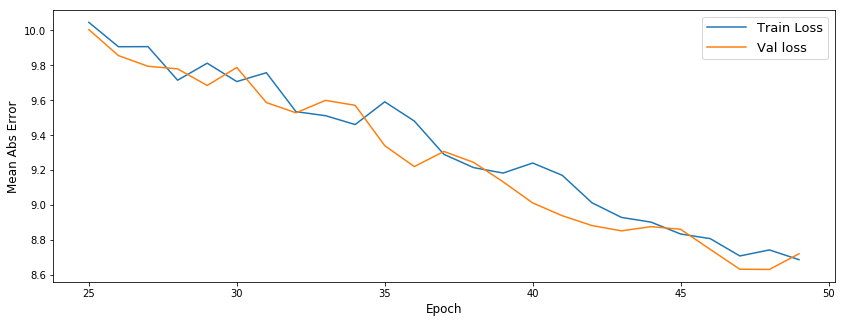

In [49]:
plot_history(model_hist2)

In [48]:
model.save_weights('./model_checkpoints/weights_batch100_3layer_402010_250d_')
model.save('./model_checkpoints/model_batch100_3layer_402010_250d')

In [15]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(40, activation=tf.nn.relu,
                       input_shape=(len(feature_cols),),
                       name='hidden_layer_1',),
    keras.layers.Dense(20, activation=tf.nn.relu, 
                       name='hidden_layer_2'),
    keras.layers.Dense(10, activation=tf.nn.relu, 
                       name='hidden_layer_3'),
    keras.layers.Dense(2, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
model.compile(loss='mse',
            optimizer='adam',
            metrics=['mae', 'mse', 'accuracy'])

# show a summary of the data
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 40)                1600      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 20)                820       
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 10)                210       
_________________________________________________________________
output_layer (Dense)         (None, 2)                 22        
Total params: 2,652
Trainable params: 2,652
Non-trainable params: 0
_________________________________________________________________


In [16]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 14, 'axes.labelsize' : 12,
      'legend.fontsize' : 13,'legend.handlelength': 3})

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

lw=2
aph=.2

plt.rcParams['figure.figsize'] = (14.,5.)



In [17]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('acc'))
        self.val_accuracy.append(logs.get('val_acc'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel('Mean Square Error');
        plt.subplot(122)
        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.plot(self.x, self.val_accuracy, label="val_accuracy")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel('Model Accuracy');
        plt.show();
        
plot_losses = PlotLosses()

# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 5])

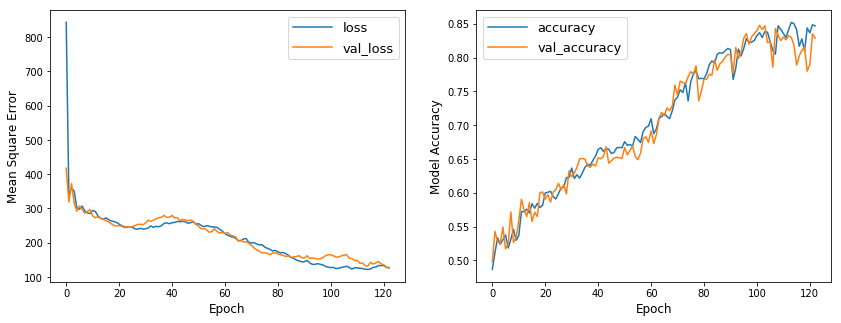

5/5 [==============================] - 448s 90s/step - loss: 127.4828 - mean_absolute_error: 5.9568 - mean_squared_error: 127.4828 - acc: 0.8468 - val_loss: 126.2762 - val_mean_absolute_error: 6.4262 - val_mean_squared_error: 126.2762 - val_acc: 0.8285
Epoch 124/150
4/5 [=======================>......] - ETA: 6s - loss: 123.3259 - mean_absolute_error: 5.7850 - mean_squared_error: 123.3259 - acc: 0.8552 

In [ ]:
model_hist = model.fit_generator(generator=actual_generator(w_validation=True, choice='training'),
                                 validation_data=actual_generator(w_validation=True, choice='validation'),
                                 steps_per_epoch=5, validation_steps=5, epochs=150, callbacks=[plot_losses])#, use_multiprocessing=True, workers=10)


In [24]:
# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
#plt.rcParams['figure.figsize'] = (14.,5.)
def plot_history(history, xlim):
    plt.figure(figsize=(18,4))
    plt.subplot(131)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Mean squared error)')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([20, 350])
    plt.xlim(xlim)
    plt.subplot(132)
    plt.xlabel('Epoch')
    plt.ylabel(r'Mean Abs Error [$cm/s$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Training')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Validation')
    plt.legend()
    plt.ylim([3, 13])
    plt.xlim(xlim)

    plt.subplot(133)
    plt.xlabel('Epoch')
    plt.ylabel(r'Model Accuracy [$\%$]')
    plt.plot(history.epoch, np.array(history.history['acc']),
           label='Training')
    plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Validation')
    plt.legend()
    plt.ylim([0.4, 0.95])
    plt.xlim(xlim)


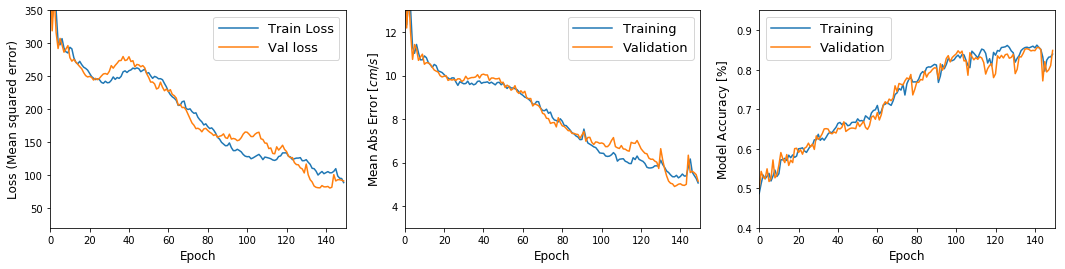

In [37]:
plot_history(model_hist, xlim=[0,150])
plt.savefig('Figs_regression/NN3layer_train_globe_1dbatch_5dperepoch.pdf')

In [25]:
vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V']
bg = BatchGenerator(ds.reset_coords()[vars_wanted],
                    input_dims={'nlon': 100, 'nlat': 100}, batch_dims={'time': 1},
                    input_overlap={'nlon' : 1, 'nlat' : 1},
                    concat_input_dims=True)
for batch in bg:
    break

In [26]:
batch

<xarray.Dataset>
Dimensions:      (nlat_input: 100, nlon_input: 100, sample: 864)
Coordinates:
  * sample       (sample) MultiIndex
  - time         (sample) object   46-01-02 00:00:00 ...   46-01-02 00:00:00
  - input_batch  (sample) int64 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28 29
Dimensions without coordinates: nlat_input, nlon_input
Data variables:
    SST          (sample, nlon_input, nlat_input) float32 nan nan ... nan nan
    SSH          (sample, nlon_input, nlat_input) float32 nan nan ... nan nan
    TAUX         (sample, nlon_input, nlat_input) float32 nan nan ... nan nan
    TAUY         (sample, nlon_input, nlat_input) float32 nan nan ... nan nan
    XU           (sample, nlon_input, nlat_input) float64 -1.0 -1.0 ... -1.0
    YU           (sample, nlon_input, nlat_input) float64 -1.0 -1.0 ... -1.0
    U            (sample, nlon_input, nlat_input) float32 nan nan ... nan nan
    V            (sample, nlon_input, nlat_input) float32 nan nan ... nan nan
Attributes:
    C

In [36]:
model.save_weights('./model_checkpoints/weights_batch1day_3layer_402010_750d')
model.save('./model_checkpoints/model_batch1day_3layer_402010_750d')

In [67]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(40, activation=tf.nn.relu,
                       input_shape=(len(feature_cols),),
                       name='hidden_layer_1',),
    keras.layers.Dense(20, activation=tf.nn.relu, 
                       name='hidden_layer_2'),
    keras.layers.Dense(10, activation=tf.nn.relu, 
                       name='hidden_layer_3'),
    keras.layers.Dense(2, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
model.compile(loss='mse',
            optimizer='adam',
            metrics=['mae', 'mse', 'accuracy'])

# show a summary of the data
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 40)                1600      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 20)                820       
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 10)                210       
_________________________________________________________________
output_layer (Dense)         (None, 2)                 22        
Total params: 2,652
Trainable params: 2,652
Non-trainable params: 0
_________________________________________________________________


In [68]:
def actual_generator(**kwargs):
    vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V']
    bg = BatchGenerator(ds.reset_coords()[vars_wanted],
                    input_dims={'nlon': 100, 'nlat': 100}, batch_dims={'time': 1},
                    concat_input_dims=True)
    for batch in bg:
        yield  ds_to_df(extract_needed_variables(batch), kwargs)

In [70]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

plt.rcParams['figure.figsize'] = (16.,5.)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.mae = []
        self.val_mae = []
        self.accuracy = []
        self.val_accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.mae.append(logs.get('mean_absolute_error'))
        self.val_mae.append(logs.get('val_mean_absolute_error'))
        self.accuracy.append(logs.get('acc'))
        self.val_accuracy.append(logs.get('val_acc'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.subplot(131)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="val loss")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel('Mean Squared Error');
        plt.subplot(132)
        plt.plot(self.x, self.mae, label="training")
        plt.plot(self.x, self.val_mae, label="validation")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel(r'Mean Absolute Error [$cm/s$]');
        plt.subplot(133)
        plt.plot(self.x, self.accuracy, label="training accuracy")
        plt.plot(self.x, self.val_accuracy, label="validation accuracy")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel(r'Model Accuracy [$\%$]');
        plt.tight_layout()
        plt.show();
        
plot_losses = PlotLosses()


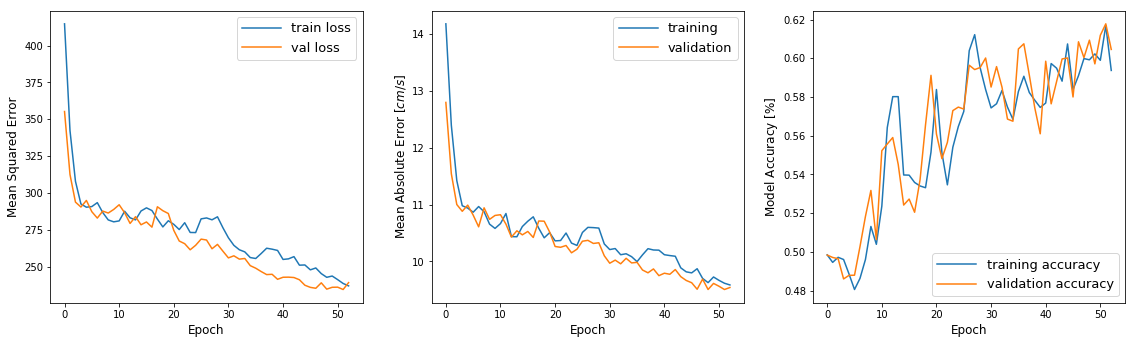

2/2 [==============================] - 195s 98s/step - loss: 236.8533 - mean_absolute_error: 9.5854 - mean_squared_error: 236.8533 - acc: 0.5937 - val_loss: 239.0803 - val_mean_absolute_error: 9.5404 - val_mean_squared_error: 239.0803 - val_acc: 0.6046
Epoch 54/500
1/2 [==============>...............] - ETA: 6s - loss: 235.4680 - mean_absolute_error: 9.5999 - mean_squared_error: 235.4680 - acc: 0.6069

In [ ]:
model_hist = model.fit_generator(generator=actual_generator(w_validation=True, choice='training'),
                                 validation_data=actual_generator(w_validation=True, choice='validation'),
                                 steps_per_epoch=2, validation_steps=2, epochs=500, callbacks=[plot_losses])#, use_multiprocessing=True, workers=10)


In [ ]:
plot_history(model_hist, xlim=[-10,500])

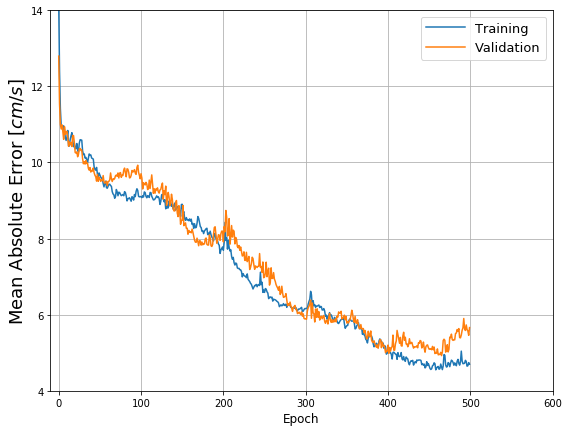

In [73]:
plt.figure(figsize=(9,7))
plt.plot(model_hist.epoch, np.array(model_hist.history['mean_absolute_error']), label='Training')
plt.plot(model_hist.epoch, np.array(model_hist.history['val_mean_absolute_error']), label='Validation')
plt.xlabel('Epoch')
plt.ylabel(r'Mean Absolute Error [$cm/s$]', fontsize=18)
plt.legend()
plt.xlim([-10,600])
plt.ylim([4,14])
plt.grid()

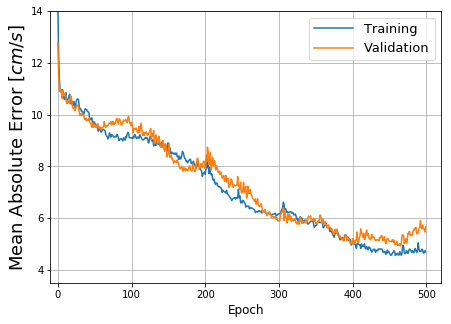

In [77]:
plt.figure(figsize=(7,5))
plt.plot(model_hist.epoch, np.array(model_hist.history['mean_absolute_error']), label='Training')
plt.plot(model_hist.epoch, np.array(model_hist.history['val_mean_absolute_error']), label='Validation')
plt.xlabel('Epoch')
plt.ylabel(r'Mean Absolute Error [$cm/s$]', fontsize=18)
plt.legend()
plt.xlim([-10,520])
plt.ylim([3.5,14])
plt.grid()

plt.savefig('Figs_regression/NN3layer_MAE_train_globe_1dbatch_2perepoch.pdf')

In [62]:
len(model_hist.history['loss'])

150

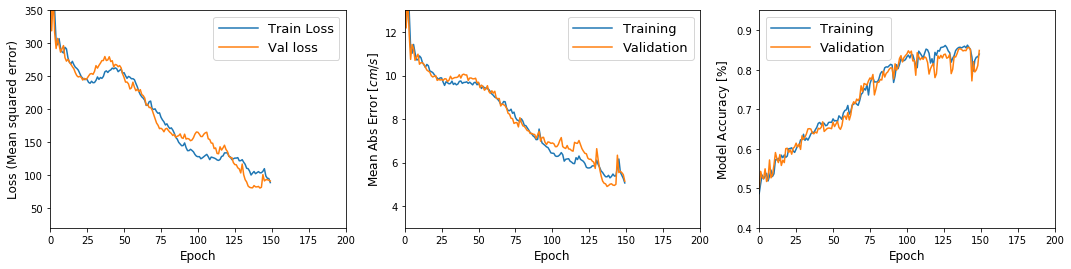

In [58]:
plot_history(model_hist, xlim=[0,200])

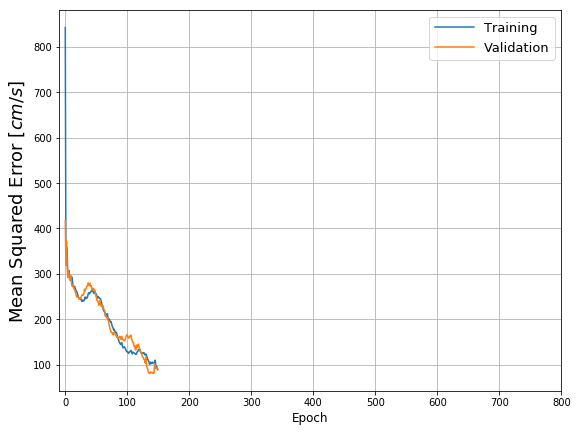

In [59]:
plt.figure(figsize=(9,7))
plt.plot(model_hist.epoch, np.array(model_hist.history['loss']), label='Training')
plt.plot(model_hist.epoch, np.array(model_hist.history['val_loss']), label='Validation')
plt.xlabel('Epoch')
plt.ylabel(r'Mean Squared Error [$cm/s$]', fontsize=18)
plt.legend()
plt.xlim([-10,800])
#plt.ylim([4,14])
plt.grid()

In [28]:
X, y = ds_to_df(extract_needed_variables(batch))
len(X)

5137262

In [33]:
len(X)/2

2568631.0

In [35]:
5137*1000

5137000

In [ ]:
def actual_generator(**kwargs):
    vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V']
    bg = BatchGenerator(ds.reset_coords()[vars_wanted],
                    input_dims={'nlon': 100, 'nlat': 100}, batch_dims={'time': 1},
                    input_overlap={'nlon' : 1, 'nlat' : 1},
                    concat_input_dims=True)
    for batch in bg:
        yield  ds_to_df(extract_needed_variables(batch), kwargs)